In [1]:
# Standard Python modules
import os, sys
import glob
import yaml
import numpy as np
import pandas as pd
import xarray as xr
import netCDF4 as nc
import textwrap
# matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colorbar import Colorbar # different way to handle colorbar
# plot styles/formatting
import seaborn as sns
import cmocean.cm as cmo
import cmocean
# cartopy
import cartopy.crs as ccrs

# Extra 
from scipy.ndimage import gaussian_filter    # smoothing contour lines
import wrf

# import personal modules

# Path to modules
sys.path.append('../modules')

# Import my modules
from plotter import draw_basemap, make_cmap, plot_maxmin_points
import nclcmaps as nclc
from utils import find_perpindicular_line, find_parallel_line, find_intersection_two_lines, add_days_to_date
from wrf_funcs_preprocess import calculate_WRF_vertical_cross_static

In [2]:
# Set up paths
path_to_data = '/home/nash/DATA/data/' # project data -- read only
path_to_out  = '../out/'       # output files (numerical results, intermediate datafiles) -- read & write
path_to_figs = '../figs/'      # figures


## Import AR Data

In [3]:
arname = 'jan1989'
manual = True
# import configuration file for case study choice
yaml_doc = '../data/config_files/ar_casestudy.yml'
config = yaml.load(open(yaml_doc), Loader=yaml.SafeLoader)
ar_dict = config[arname]

year = ar_dict['year']
month = ar_dict['month']
start_date = ar_dict['start_date']
end_date = add_days_to_date(ar_dict['end_date'], 1)
print(start_date, end_date)
ar_ID = ar_dict['ar_ID']
print(ar_ID)

date_lst = pd.date_range(start_date, end_date, freq='1D')

# Select lat/lon grid
lonmin = 60
lonmax = 115
latmin = 15
latmax = 60

1989-01-03 1989-01-07
[31016]


In [4]:
## points of landslides (chosen in fig10_wvf_climatology-analysis.ipynb)
pt1 = [72.6625, 34.8733]
pt2 = [74.0225, 34.0876]

ptlst = [pt1, pt2]

# hlat, hlon, tlat, tlon
Line1 = [pt1[1], pt1[0], pt2[1], pt2[0]] # this line is a line between the 2 landslide points
x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# calculate perpindicular line to line between landslide points at x for pt1 and pt2
newx_lst = [pt1[0], pt2[0]]
newline = []
x3_lst = [70.5, 72.]
for i, newx in enumerate(newx_lst):
    # get perpindicular line
    line, eq = find_perpindicular_line(x1, y1, x2, y2, newx, x3=x3_lst[i])
    newline.append(line)

In [5]:
## points of landslides (chosen in fig10_wvf_climatology-analysis.ipynb)
pt1 = [72.6625, 34.8733]
pt2 = [74.0225, 34.0876]
# Line1 = [latmin, lonmin, latmax, lonmax] 

line1 = [32., pt1[0], 35., pt1[0]]
line2 = [32., pt2[0], 35., pt2[0]]

newline = [line1, line2]
stars = [pt1[1], pt2[1]] # location of landslide in cross section

In [6]:
# ## Get lines and points for mesoscale analysis

# # hlat, hlon, tlat, tlon
# Line1 = [39.5, 71., 32.25, 81.]
# x1, y1, x2, y2 = Line1[3],Line1[2],Line1[1],Line1[0]

# # calculate parallel lines
# Line2, eq1, eq2 = find_parallel_line(x1, y1, x2, y2, -3., 69.,  80.)
# Line3, eq1, eq3 = find_parallel_line(x1, y1, x2, y2, -2., 69.,  80.)

# ## calculate perpindicular cross section lines
# newx_lst = [74.5, 76., 76.25, 78.5]
# newx_lst = [74.25, 76.25]
# newline = []
# ptlst = []
# for i, newx in enumerate(newx_lst):
#     # get perpindicular line
#     line, eq = find_perpindicular_line(x1, y1, x2, y2, newx)
#     newline.append(line)
#     # get intersecting point for each newline and Line3
#     pt = find_intersection_two_lines(eq2[0], eq2[1], eq[0], eq[1])
#     ptlst.append(pt)

### Load 2D WRF data

In [7]:
%%time
domains = ['d01', 'd01', 'd02', 'd01', 'd02']
varname_lst = ['ivt', 'geopotential', 'prec', 'zerodegisotherm', 'sr']
res_lst = ['3hr', '3hr', 'daily', '3hr', '3hr']


## loop through each ds
ds_lst = []
for i, (dom, varname, res) in enumerate(zip(domains, varname_lst, res_lst)):
    data_path = path_to_data + 'wrf_hasia/'

    if res == 'daily':
        filename_pattern = '{0}/{1}/daily/out.wrf6km.{1}.daily_{2}.nc'.format(dom, varname, year)
    else: 
        filename_pattern = '{0}/{1}/3hr/tmp_{2}.nc'.format(dom, varname, year)
    
    fname = data_path + filename_pattern
    print(fname)
    ds = xr.open_dataset(fname)
    
    # subset to just ar days
    ds = ds.sel(time = slice(start_date, end_date))
    
    if varname == 'ivt':
        ds = ds.assign(ivt=lambda ds: np.sqrt(ds.ivtu**2 + ds.ivtv**2))
    if varname == 'geopotential':
        ds = ds.sel(lev=250.)
    
    if (arname == 'feb1998') & (varname != 'prec'):
        # select the 06 UTC hour 
        ds = ds.sel(time=ds.time.dt.hour == 6)
    elif (arname == 'jan1989') & (varname != 'prec'):
        # select the 06 UTC hour 
        ds = ds.sel(time=ds.time.dt.hour == 12)
    else:
        # select the 00 UTC hour 
        ds = ds.sel(time=ds.time.dt.hour == 0)
    
    ds_lst.append(ds)
    

dates = ds_lst[0].time.values # get time values for cross sections
ds_lst[0]

/home/nash/DATA/data/wrf_hasia/d01/ivt/3hr/tmp_1989.nc
/home/nash/DATA/data/wrf_hasia/d01/geopotential/3hr/tmp_1989.nc
/home/nash/DATA/data/wrf_hasia/d02/prec/daily/out.wrf6km.prec.daily_1989.nc
/home/nash/DATA/data/wrf_hasia/d01/zerodegisotherm/3hr/tmp_1989.nc
/home/nash/DATA/data/wrf_hasia/d02/sr/3hr/tmp_1989.nc
CPU times: user 260 ms, sys: 108 ms, total: 367 ms
Wall time: 480 ms


<xarray.Dataset>
Dimensions:  (time: 5, lat: 249, lon: 259)
Coordinates:
  * time     (time) datetime64[ns] 1989-01-03T12:00:00 ... 1989-01-07T12:00:00
  * lat      (lat) float32 16.43 16.63 16.83 17.02 ... 55.8 55.92 56.04 56.15
  * lon      (lon) float32 60.2 60.41 60.62 60.83 ... 113.2 113.4 113.6 113.8
Data variables:
    ivtu     (time, lat, lon) float64 -98.91 -97.83 -96.16 ... 12.55 12.1 12.25
    ivtv     (time, lat, lon) float64 -19.17 -18.72 -17.76 ... -7.706 -7.84
    iwv      (time, lat, lon) float64 ...
    ivt      (time, lat, lon) float64 100.8 99.6 97.79 ... 14.85 14.35 14.55

In [8]:
# ds_lst[2]

ds2_ext = [22.05, 40.33, 68.24, 99.12]

## Calculate Cross Sections

In [9]:
%%time
## TODO: will need to update this if I start running on Frontera
# unprocessed 6.7 km wrf filenames
wrf_filenames = ar_dict['wrf_files'] # this only works on great

varlst = ('pressure', 'theta_e', 'theta', 'rh', 'ua', 'va', 'wa', 'wspd', 'QVAPOR', 'z', 'omega', 'QSNOW')
cross_lst = []
for i, line in enumerate(newline):
    # hlat, hlon, tlat, tlon
    cross_lst.append(calculate_WRF_vertical_cross_static(wrf_filenames, varlst, dates, line[0], line[1], line[2], line[3]))

cross_lst[0][0]

/home/hasia/1988/wrfout_d02_1988-12-31_03:00:00 timeidx is  27
CoordPair(lat=32.0, lon=72.6625) CoordPair(lat=35.0, lon=72.6625)
/home/hasia/1988/wrfout_d02_1988-12-31_03:00:00 timeidx is  35
CoordPair(lat=32.0, lon=72.6625) CoordPair(lat=35.0, lon=72.6625)
/home/hasia/1988/wrfout_d02_1989-01-05_03:00:00 timeidx is  3
CoordPair(lat=32.0, lon=72.6625) CoordPair(lat=35.0, lon=72.6625)
/home/hasia/1988/wrfout_d02_1989-01-05_03:00:00 timeidx is  11
CoordPair(lat=32.0, lon=72.6625) CoordPair(lat=35.0, lon=72.6625)
/home/hasia/1988/wrfout_d02_1989-01-05_03:00:00 timeidx is  19
CoordPair(lat=32.0, lon=72.6625) CoordPair(lat=35.0, lon=72.6625)
/home/hasia/1988/wrfout_d02_1988-12-31_03:00:00 timeidx is  27
CoordPair(lat=32.0, lon=74.0225) CoordPair(lat=35.0, lon=74.0225)
/home/hasia/1988/wrfout_d02_1988-12-31_03:00:00 timeidx is  35
CoordPair(lat=32.0, lon=74.0225) CoordPair(lat=35.0, lon=74.0225)
/home/hasia/1988/wrfout_d02_1989-01-05_03:00:00 timeidx is  3
CoordPair(lat=32.0, lon=74.0225) Coo

<xarray.Dataset>
Dimensions:          (cross_line_idx: 53, vertical: 121)
Coordinates:
    XTIME            float32 4.442e+05
    Time             datetime64[ns] 1989-01-03T12:00:00
    xy_loc           (cross_line_idx) object CoordPair(x=64.0, y=162.0, lat=3...
  * vertical         (vertical) float32 0.0 100.0 200.0 ... 1.19e+04 1.2e+04
    wspd_wdir        <U4 'wspd'
Dimensions without coordinates: cross_line_idx
Data variables: (12/15)
    pressure_cross   (vertical, cross_line_idx) float32 nan nan ... 198.7 197.9
    theta_e_cross    (vertical, cross_line_idx) float32 nan nan ... 343.8 343.3
    theta_cross      (vertical, cross_line_idx) float32 nan nan ... 343.8 343.3
    rh_cross         (vertical, cross_line_idx) float32 nan nan ... 11.28 9.741
    ua_cross         (vertical, cross_line_idx) float32 nan nan ... 56.22 55.43
    va_cross         (vertical, cross_line_idx) float32 nan nan ... -11.72
    ...               ...
    height_cross     (vertical, cross_line_idx) float32 nan nan nan ... nan nan
    omega_cross      (vertical, cross_line_idx) float32 nan nan ... 0.1697 1.943
    QSNOW_cross      (vertical, cross_line_idx) float32 nan nan nan ... 0.0 0.0
    q                (vertical, cross_line_idx) float32 nan nan ... 6.213e-06
    wvf              (vertical, cross_line_idx) float32 nan nan ... 0.000352
    ter              (cross_line_idx) float32 186.0 189.0 ... 2.634e+03

In [10]:
## hacked this for now - not really sure how to index these cross sections
## get cross_idx of landslide loc
cross_idx1 = cross_lst[0][0].cross_line_idx[-4].values
cross_idx2 = cross_lst[1][0].cross_line_idx.cross_line_idx[-18].values

cross_idx_lst = [cross_idx1, cross_idx2]
# pt1 = [72.6625, 34.8733]
# pt2 = [74.0225, 34.0876]

### Terrain for 2D maps

### Precipitation and Freezing Level cross interpolation

In [11]:

wrfin = nc.Dataset(wrf_filenames[0])
terrain = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height
terline = []
for i, line in enumerate(newline):
    # Set the start point and end point for the cross section
    start_point = wrf.CoordPair(lat=line[0], lon=line[1])
    end_point = wrf.CoordPair(lat=line[2], lon=line[3])
    print(start_point, end_point)
    tmp = wrf.interpline(terrain, wrfin=wrfin, start_point=start_point, end_point=end_point, latlon=True)
    terline.append(tmp)

CoordPair(lat=32.0, lon=72.6625) CoordPair(lat=35.0, lon=72.6625)
CoordPair(lat=32.0, lon=74.0225) CoordPair(lat=35.0, lon=74.0225)


In [12]:
# interpolate precipitation and snow across cross section line
varlst = ['prec', 'snow', 'z']
datalst = [ds_lst[2], ds_lst[2], ds_lst[3]]
    
final_cross = []
for i, (var, data) in enumerate(zip(varlst, datalst)):
    v = data[var]
    cross = []
    for j, ter in enumerate(terline):
        # get the along AR axis coord_pairs for that timestep
        coord_pairs = ter.coords["xy_loc"].values
        yvals = [pair.lat for pair in coord_pairs]
        xvals = [pair.lon for pair in coord_pairs]
        x = xr.DataArray(xvals, dims="z")
        y = xr.DataArray(yvals, dims="z")
        cross.append(v.interp(lon=x, lat=y))
        
    final_cross.append(cross)
    
prec_crs = final_cross[0]
snow_crs = final_cross[1]
freeze_crs = final_cross[2]

In [13]:
# prec_crs[0].sel(lat=34.85048, lon=72.667175)
prec_crs[0].isel(time=3, z=-4).values

array(6.63208, dtype=float32)

In [14]:
snow_crs[0].isel(time=3, z=-4).values

array(6.663162, dtype=float32)

In [15]:
## get d01 terrain for synoptic plots
fname = ar_dict['wrf_files2'][0]
wrfin = nc.Dataset(fname)
terrain = wrf.getvar(wrfin, 'ter', timeidx=0) # get terrain height

## Plot Cross Sections

For a helpful tutorial on building a plotting grid using GridSpec - visit [this blog post](http://www.sc.eso.org/~bdias/pycoffee/codes/20160407/gridspec_demo.html).

In [16]:
# Set seaborn plot style
sns.set()
sns.set_style("ticks", {'patch.force_edgecolor':False})

# Set projections (NOTE THESE ARE SWAPPED FOR WRF FOR SOME REASON)
datacrs = ccrs.PlateCarree()   # data/source
mapcrs = ccrs.PlateCarree()       # map/destination 

# Set tick/grid locations
dx = np.arange(lonmin,lonmax+10,10)
dy = np.arange(latmin,latmax+10,10)

# list of letters to append to titles
letter_lst = list(map(chr, range(97, 123)))

row_lbl = []
for i in range(len(ds_lst[0].time.values)):
    date = ds_lst[0].time[i].values
    t = pd.to_datetime(str(date)) 
    timestring = t.strftime('%Y-%m-%d %H:00')
    ttl = "({0}) ".format(letter_lst[i]) + timestring
    row_lbl.append(ttl)

# get lats and lons for plotting for d01
lats = ds_lst[0]['lat'].values
lons = ds_lst[0]['lon'].values
ext = [lons.min(), lons.max()-21, lats.min(), lats.max()-15]
print(ext)

# get lats and lons for plotting for d02
lats2 = ds_lst[2]['lat'].values
lons2 = ds_lst[2]['lon'].values

ext2 = ar_dict['ext2']
ext2 = [69.0, 82.0, 30.0, 40.]
# ext2 = [lons2.min(), lons2.max(), lats2.min(), lats2.max()]
ext3 = ar_dict['ext3']
ext3 = [60.2, 93.0, 20.0, 45.]

# Set tick/grid locations for d02
dx2 = np.arange(round(lons2.min(), 0),round(lons2.max()+1, 0),2)
dy2 = np.arange(round(lats2.min(), 0),round(lats2.max()+1, 0),2)



[60.203857, 92.796142578125, 16.428108, 41.15325927734375]


In [17]:
def add_lines_and_points(ax):
    # Contour Lines (terrain)
    terclevs=np.array([1000, 3000])
    terlons = terrain.XLONG.isel(south_north=0).values
    terlats = terrain.XLAT.isel(west_east=0).values
    kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
    cster = ax.contour(terlons, terlats, terrain.values, terclevs, colors='k', linewidths=1.0,
                    linestyles='solid', transform=datacrs)
    
    # # Plot Location of ZHAMBYL radiosonde location
    # ax.plot(71.38, 42.85, 'k^', markersize=8, transform=mapcrs)
    # # Plot Location of DELHI radiosonde location
    # ax.plot(77.20, 28.58, 'kv', markersize=8, transform=mapcrs)
    # plot landslide location (if true)
    # plot landslide location (if true)
    # ax.plot(ar_dict['landslide_loc'][0], ar_dict['landslide_loc'][1], alpha=0.7,
    #         marker='D', mec='k', mfc='#efa91b', markersize=8, transform=mapcrs)

    # add cross section lines
    for i, line in enumerate(newline):
        ax.plot([line[1], line[3]],
                    [line[0], line[2]], color='#FEBC11', marker="o",
                    transform=datacrs, zorder=3)
    
    return ax

### IVT and WV Flux Cross Sections

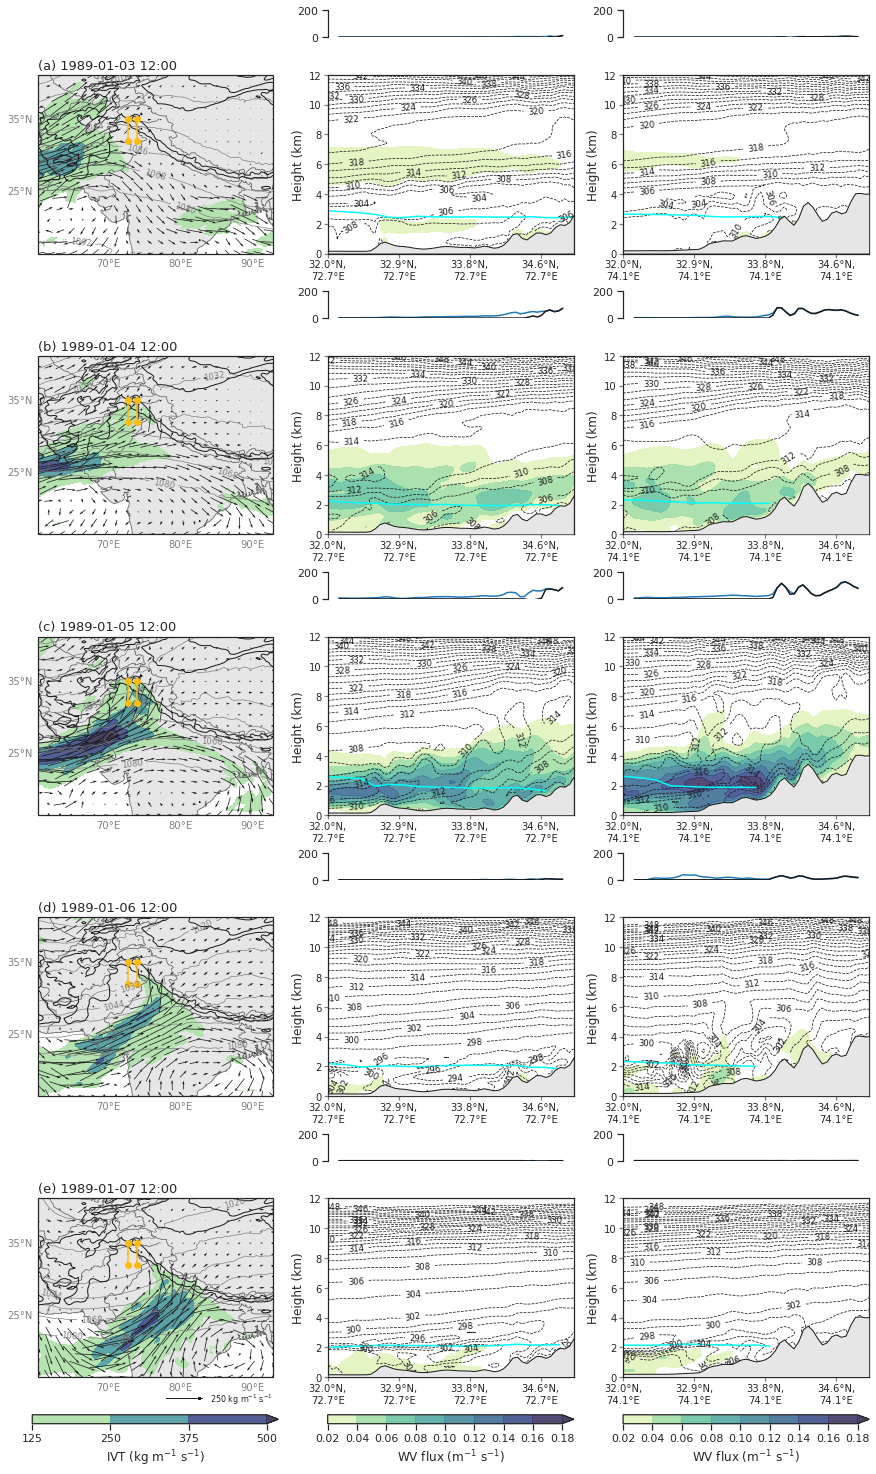

In [18]:
filepath = path_to_figs + arname + '_IVT_daily.png'
# rows is number of days in event plus 1 for colorbar
# nrows = len(ds.time)+1
nrows = (len(ds.time)*2)+1
# three columns - 
## one for synoptic maps, 
## one for vertical cross sections along AR axis
## one for vertical cross sections across AR core
ncols = 3

# Create figure
fig = plt.figure(figsize=(15,(len(ds.time)*5)+1))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
# gs = GridSpec(nrows, ncols, height_ratios=[1]*(nrows-1) + [0.05], width_ratios = [1, 1])
gs = GridSpec(nrows, ncols, height_ratios=[0.15, 1]*int((nrows-1)/2) + [0.05], width_ratios = [1, 1, 1], hspace=0.4)
## use gs[rows index, columns index] to access grids
# Now, create the gridspec structure, as required

# synoptic scale plots
rowid = np.arange(nrows-1)
for k, other in enumerate(rowid[1::2]):
    ax = fig.add_subplot(gs[other, 0], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False)

    # Contour Filled (IVT)
    data = ds_lst[0]
    uvec = data.ivtu.isel(time=k).values
    vvec = data.ivtv.isel(time=k).values
    ivt = data.ivt.isel(time=k).values
    cflevs = np.arange(125, 510, 125)
    clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
    cf = ax.contourf(data.lon.values, data.lat.values, ivt, transform=datacrs,
                     levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max')

    # Wind barbs / vectors (IVT)
    Q = ax.quiver(data.lon.values, data.lat.values, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=17, pivot='middle',
                  angles='xy', scale_units='xy', scale=50, units='xy')
    
    # Contour Lines (250Z)
    z = ds_lst[1].z.isel(time=k).values/(10.) # convert to dekameters
    clevs=np.arange(840, 1280, 12)
    cs = ax.contour(data.lon.values, data.lat.values, z, clevs, colors='grey', linewidths=0.7,
                    linestyles='solid', transform=datacrs)
    kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%d',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    add_lines_and_points(ax)
    
    # subtitles
    ax.set_title(row_lbl[k], loc='left',fontsize=13)

# quiver key
qk = ax.quiverkey(Q, 0.7, -0.12, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})
    
# Add color bar
cbax = plt.subplot(gs[-1,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)')

datalst = cross_lst
latlon_lst = [15, 15]
for j, data in enumerate(datalst):
    # vertical cross section plots - across AR
    for k, other in enumerate(rowid[1::2]):
        ax = fig.add_subplot(gs[other, j+1:j+2])
        cross = data[k]
        ## use ds.bfill to fill nan values close to mountain range
        cross = cross.bfill(dim='vertical', limit=None)
        xs = np.arange(0, len(cross.cross_line_idx), 1)
        ys = cross["vertical"].values/1000.0 #convert to km

        # Fill in the mountain area
        terline = cross.ter.values/1000.0 #convert to km
        ht_fill = ax.fill_between(xs, 0, terline, facecolor='0.9', edgecolor='k', zorder=10)

        # thetaE contours
        clevs = np.arange(270, 350, 2)
        cs = ax.contour(xs, ys, cross.theta_e_cross.values, levels=clevs, 
                        colors='k', linewidths=0.75, linestyles='dashed', zorder=2)
        kw_clabels = {'fontsize': 8.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
                  'rightside_up': True, 'use_clabeltext': True}
        plt.clabel(cs, **kw_clabels)

    #     # normal isotachs contours
    #     clevs = np.arange(0, 100, 5)
    #     wspd_cs = cross.wspd_cross.values
    #     cs = ax.contour(xs, ys, wspd_cs, levels=clevs, 
    #                     colors='blue', linewidths=1., linestyles='solid', zorder=100)
    #     plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 

        # Filled contours (WV flux)
        cflevs = np.arange(0.02, 0.20, 0.02)
        cf = ax.contourf(xs, ys, cross.wvf.values, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)

        # # zonal wind vectors
        # dw = 6
        # ax.quiver(xs[::dw], ys[::dw], cross.ua_cross.values[::dw, ::dw], cross.wa_cross.values[::dw, ::dw]*100)

        ## add in freezing level height
        y = freeze_crs[j].isel(time=k).values / 1000. # convert from m to km
        freeze_line = ax.plot(xs, y, c='cyan', lw=1.5)

        # Set the x-ticks to use latitude and longitude labels
        coord_pairs = cross.coords["xy_loc"].values
        x_ticks = np.arange(coord_pairs.shape[0])
        x_labels = [u"{:.1f}\N{DEGREE SIGN}N, {:.1f}\N{DEGREE SIGN}E".format(pair.lat, pair.lon) for pair in coord_pairs]
        # set the frequency of xtick labels
        skip = latlon_lst[j]
        ax.set_xticks(x_ticks[::skip])
        ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[::skip]], fontsize=10)

        # Set the yaxis label
        ax.set_ylabel("Height (km)", fontsize=12)

        # apply tick parameters    
        ax.tick_params(direction='out', 
                       labelsize=10, 
                       length=4, 
                       pad=2, 
                       color='gray')
    
    # Add color bar
    cbax = plt.subplot(gs[-1,j+1]) # colorbar axis
    cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
    cb.set_label('WV flux (m$^{-1}$ s$^{-1}$)')
    
for j, (prec, snow) in enumerate(zip(prec_crs, snow_crs)):    
    ## Add rain and snow line plot
    for k, other in enumerate(rowid[::2]):
        ax = fig.add_subplot(gs[other, j+1:j+2])

        # WRF Precip
        x = prec.isel(time=k).lat.values
        y = prec.isel(time=k).values
        ax.plot(x, y, color='tab:blue')

        # WRF SNOW
        y = snow.isel(time=k).values
        ax.plot(x, y, color='k')

        # some plot parameters to make it look nice
        ax.set_ylim(0, 200)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
    #     ax.spines['left'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.get_xaxis().set_ticks([])
    #     ax.get_yaxis().set_ticks([])

## Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


### Water Vapor and Ice Mixing Ratio Cross Sections

0.0 54.819336
0.0 99.831055
0.0 179.4082
0.0 146.9458
0.0 113.62024
0.0 0.20138817
0.0 0.88935083
0.0 1.9943148
0.0 0.0


/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.
/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


0.0 0.0
0.0 0.1283925
0.0 0.8334482
0.0 2.1019497
0.0 2.8066852
0.0 0.0


/home/sbarc/students/nash/miniconda3/envs/hasia2/lib/python3.7/site-packages/ipykernel_launcher.py:100: UserWarning: No contour levels were found within the data range.


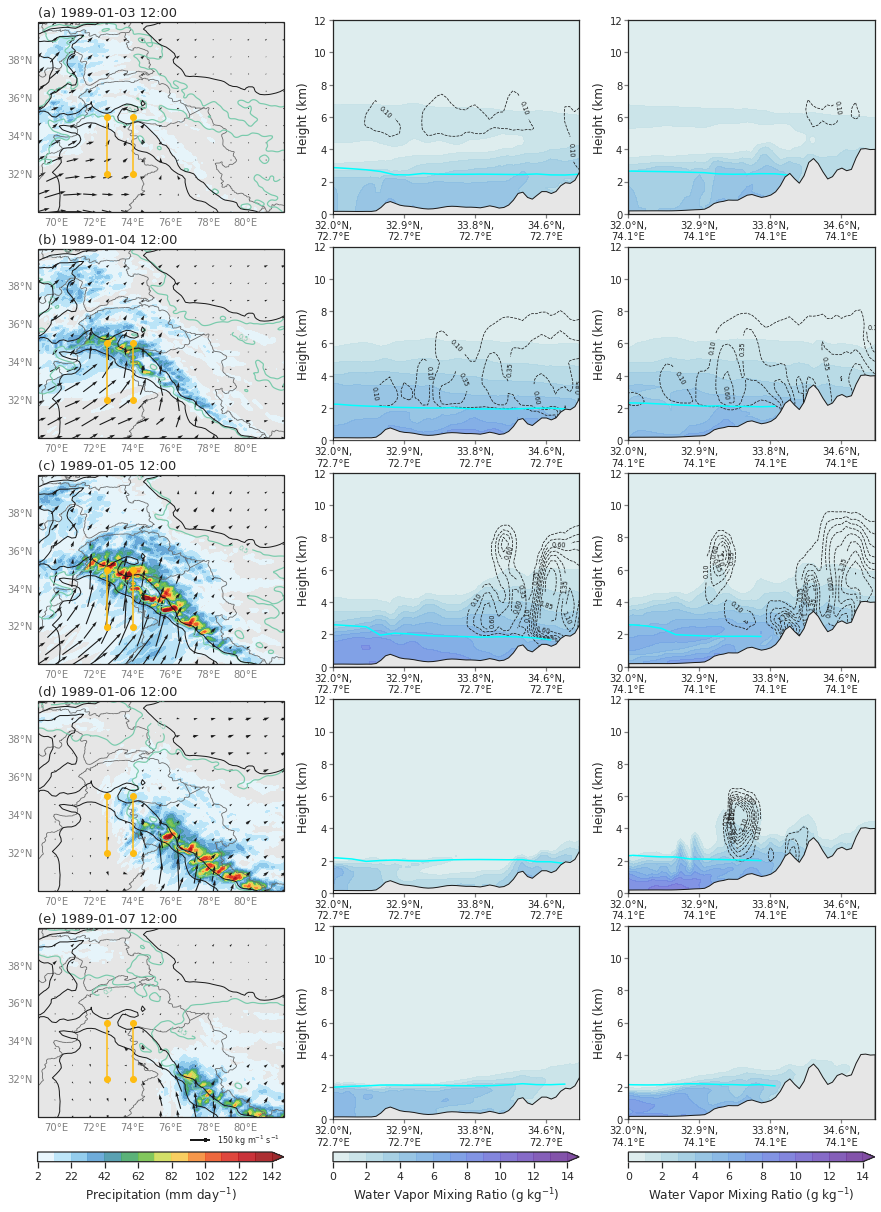

In [19]:
filepath = path_to_figs + arname + '_prec_mixingratio_cross.png'
# rows is number of days in event plus 1 for colorbar
nrows = len(ds.time)+1
# three columns - 
## one for synoptic maps, 
## one for vertical cross sections along AR axis
## one for vertical cross sections across AR core
ncols = 3

# Create figure
fig = plt.figure(figsize=(15,(len(ds.time)*4)+1))


## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[1]*(nrows-1) + [0.05], width_ratios = [1, 1, 1], hspace=0.2)
## use gs[rows index, columns index] to access grids
# Now, create the gridspec structure, as required

# synoptic scale plots
rowid = np.arange(nrows-1)
for k, other in enumerate(rowid):
    ax = fig.add_subplot(gs[other, 0], projection=mapcrs) 
    ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2, left_lats=True, right_lats=False)

    # Contour Filled
    data = ds_lst[2].prec
    prec = data.isel(time=k).values
    lats = data.lat.values
    lons = data.lon.values
    print(np.nanmin(prec), np.nanmax(prec))
    cflevs = np.arange(2, 152, 10)
    # clipcmap = cmocean.tools.crop_by_percent(cmo.rain, 10, which='max', N=None)
    cmap = nclc.cmap('WhiteBlueGreenYellowRed')
    cf = ax.contourf(lons, lats, prec, transform=datacrs,
                     levels=cflevs, cmap=cmap, alpha=0.9, extend='max')
    
    # Contour Lines (fraction of frozen precipitation)
    sr = ds_lst[4].sr.isel(time=k).values
    sr_sm = gaussian_filter(sr, sigma=1.5)
    srlats = ds_lst[4].lat.values
    srlons = ds_lst[4].lon.values
    srclevs=np.array([0.5, 1])
    cs = ax.contour(srlons, srlats, sr_sm, srclevs, colors='#79cbac', linewidths=1.2,
                    linestyles='solid', transform=datacrs)
    kw_clabels = {'fontsize': 6.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.1f',
                      'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels)
    
    # Contour Lines (IVT)
    # ivt = ds_lst[0].ivt.isel(time=k).values
    # ivt_sm = gaussian_filter(ivt, sigma=1.5)
    uvec = ds_lst[0].ivtu.isel(time=k).values
    vvec = ds_lst[0].ivtv.isel(time=k).values
    ivtlats = ds_lst[0].lat.values
    ivtlons = ds_lst[0].lon.values
    ivtclevs=np.array([125, 250, 375, 500])
    # cl = ax.contour(ivtlons, ivtlats, ivt_sm, ivtclevs, colors='#3f396c', linewidths=0.75,
    #                 linestyles='dashed', transform=datacrs)
    
    # Wind barbs / vectors (IVT)
    Q = ax.quiver(ivtlons, ivtlats, uvec, vvec, transform=datacrs, 
                  color='k', regrid_shape=12, pivot='middle',
                  angles='xy', scale_units='xy', scale=150, units='xy')
    
    # add all lines and points for the synoptic plot
    add_lines_and_points(ax)
    
    # subtitles
    ax.set_title(row_lbl[k], loc='left',fontsize=13)

# quiver key
qk = ax.quiverkey(Q, 0.7, -0.12, 150, '150 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})    
# Add color bar
cbax = plt.subplot(gs[-1,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('Precipitation (mm day$^{-1}$)')

datalst = cross_lst
latlon_lst = [15, 15]
for j, data in enumerate(datalst):
    for k, other in enumerate(range(nrows-1)):
        ax = fig.add_subplot(gs[other, j+1:j+2]) 
        cross = data[k]
        ## use ds.bfill to fill nan values close to mountain range
        cross = cross.bfill(dim='vertical', limit=None)
        xs = np.arange(0, len(cross.cross_line_idx), 1)
        ys = cross["vertical"].values/1000.0 #convert to km

        # Fill in the mountain area
        terline = cross.ter.values/1000.0 #convert to km
        ht_fill = ax.fill_between(xs, 0, terline, facecolor='0.9', edgecolor='k', zorder=10)

        # contours
        qice = cross.QSNOW_cross.values*1000 # convert to g kg-1
        print(qice.min(), qice.max())
        clevs = np.arange(0.1, 2.25, 0.25)
        cs = ax.contour(xs, ys, qice, levels=clevs, 
                        colors='k', linewidths=0.75, linestyles='dashed', zorder=2)
        kw_clabels = {'fontsize': 6.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.2f',
                      'rightside_up': True, 'use_clabeltext': True}
        plt.clabel(cs, **kw_clabels) 

        # Filled contours
        cflevs = np.arange(0, 15., 1.)
        rv_gkg = cross.QVAPOR_cross.values*1000 # convert to g kg-1
        clipcmap = cmocean.tools.crop_by_percent(cmo.dense, 30, which='max', N=None)
        cf = ax.contourf(xs, ys, rv_gkg, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)

        ## add in freezing level height
        y = freeze_crs[j].isel(time=k).values / 1000. # convert from m to km
        freeze_line = ax.plot(xs, y, c='cyan', lw=1.5)

        # Set the x-ticks to use latitude and longitude labels
        coord_pairs = cross.coords["xy_loc"].values
        x_ticks = np.arange(coord_pairs.shape[0])
        x_labels = [u"{:.1f}\N{DEGREE SIGN}N, {:.1f}\N{DEGREE SIGN}E".format(pair.lat, pair.lon) for pair in coord_pairs]
        # set the frequency of xtick labels
        skip = latlon_lst[j]
        ax.set_xticks(x_ticks[::skip])
        ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[::skip]], fontsize=10)

        # Set the yaxis label
        ax.set_ylabel("Height (km)", fontsize=12)

        # apply tick parameters    
        ax.tick_params(direction='out', 
                       labelsize=10, 
                       length=4, 
                       pad=2, 
                       color='gray')
    
    # Add color bar
    cbax = plt.subplot(gs[-1,j+1]) # colorbar axis
    cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
    cb.set_label('Water Vapor Mixing Ratio (g kg$^{-1}$)')

## Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()


## Plot most interesting time step for each case

1. top row: IVT and WV flux
2. bottom row: precipitation, frozen precipitation, and mixing ratios

In [20]:
## select single date that I want to plot
if arname == 'jan2002':
    dateofinterest = '2002-01-13 00'
    dateofinterest_prec = '2002-01-13 00'
    cross_new = [cross_lst[0][-1], cross_lst[1][-1]] # want last timestep in cross section
if arname == 'feb2010':
    dateofinterest = '2010-02-08 00'
    dateofinterest_prec = '2010-02-08 00'
    cross_new = [cross_lst[0][-2], cross_lst[1][-2]] # want second to last timestep in cross section
    
if arname == 'feb1998':
    dateofinterest = '1998-02-14 06'
    dateofinterest_prec = '1998-02-14 00'
    cross_new = [cross_lst[0][-3], cross_lst[1][-3]] # want third to last timestep in cross section
    
if arname == 'jan1989':
    dateofinterest = '1989-01-05 12'
    dateofinterest_prec = '1989-01-05 00'
    cross_new = [cross_lst[0][2], cross_lst[1][2]] # want third timestep in cross section

Max line precip: 85.031006
Max line precip: 126.112305
Precipitation min/max (mm) 0.0 179.4082
Ice mixing ratio min/max 0.0 1.9943148
Ice mixing ratio min/max 0.0 2.1019497


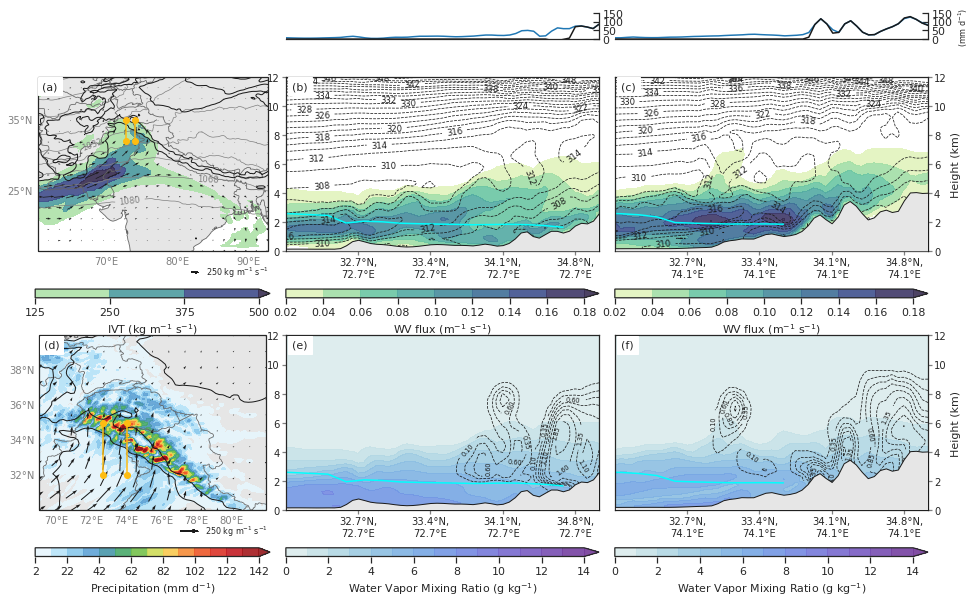

In [21]:
filepath = path_to_figs + arname + '_summary_daily.png'
nrows = 5
# three columns - 
## one for synoptic maps, 
## one for vertical cross sections along AR axis
## one for vertical cross sections across AR core
ncols = 3

# point location for (a) (b) (c) label annotation
xpt = 0.02
ypt = 0.975

# Create figure
fig = plt.figure(figsize=(16,10))

## Use gridspec to set up a plot with a series of subplots that is
## n-rows by n-columns
gs = GridSpec(nrows, ncols, height_ratios=[0.15] + [1, 0.05]*2, width_ratios = [0.75, 1, 1], hspace=0.48, wspace=0.055)
## use gs[rows index, columns index] to access grids
# Now, create the gridspec structure, as required

#########################
### Precip line plots ###
#########################
latlon_lst = [12, 12]
for j, (prec, snow) in enumerate(zip(prec_crs, snow_crs)):    
    ## Add rain and snow line plot
    ax = fig.add_subplot(gs[0, j+1:j+2])

    # WRF Precip
    x = prec.lat.values
    y = prec.sel(time=dateofinterest_prec).values
    print('Max line precip:', np.nanmax(y))
    ax.plot(x, y, color='tab:blue')

    # WRF SNOW
    y = snow.sel(time=dateofinterest_prec).values
    ax.plot(x, y, color='k')

    # some plot parameters to make it look nice
    ax.set_ylim(0, 150)
    ax.set_yticks(np.arange(0, 200, 50))
    ax.yaxis.tick_right()
    ax.tick_params(axis="y",direction="in")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(True)
    ax.spines['left'].set_visible(False)
    ax.set_xlim([x.min(),x.max()])
    
    # ax.spines['bottom'].set_visible(False)
    ax.get_xaxis().set_ticks([])
#     ax.get_yaxis().set_ticks([])
    ax.patch.set_alpha(0.0)
    
    if j > 0:
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_ylabel("(mm d$^{-1}$)", fontsize=8)

################
### IVT maps ###
################
ax = fig.add_subplot(gs[1, 0], projection=mapcrs) 
ax = draw_basemap(ax, extent=ext, xticks=dx, yticks=dy, left_lats=True, right_lats=False)

# Contour Filled (IVT)
data = ds_lst[0].sel(time=dateofinterest)
uvec = data.ivtu.values
vvec = data.ivtv.values
ivt = data.ivt.values
cflevs = np.arange(125, 510, 125)
clipcmap = cmocean.tools.crop_by_percent(cmo.deep, 10, which='max', N=None)
cf = ax.contourf(data.lon.values, data.lat.values, ivt, transform=datacrs,
                 levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max')

# Wind barbs / vectors (IVT)
Q = ax.quiver(data.lon.values, data.lat.values, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=17, pivot='middle',
              angles='xy', scale_units='xy', scale=250, units='xy')

# Contour Lines (250Z)
z = ds_lst[1].z.sel(time=dateofinterest).values/(10.) # convert to dekameters
clevs=np.arange(840, 1280, 12)
kw_clabels = {'fontsize': 5, 'inline': True, 'inline_spacing': 5, 'fmt': '%i',
              'rightside_up': True, 'use_clabeltext': True}
cs = ax.contour(data.lon.values, data.lat.values, z, clevs, colors='grey', linewidths=0.7,
                linestyles='solid', transform=datacrs)
plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5)

# quiver key
qk = ax.quiverkey(Q, 0.7, -0.12, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})

# add all lines and points for the synoptic plot
add_lines_and_points(ax)

# add text title
ax.text(xpt, ypt, '(a)', ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)
    
# Add color bar
cbax = plt.subplot(gs[2,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('IVT (kg m$^{-1}$ s$^{-1}$)', fontsize=11)

#####################
### cross-section ###
#####################
datalst = cross_new
ttl = ['(b)', '(c)']
for j, cross in enumerate(datalst):
    # vertical cross section plots - across AR

    ax = fig.add_subplot(gs[1, j+1:j+2])
    ## use ds.bfill to fill nan values close to mountain range
    cross = cross.bfill(dim='vertical', limit=None)
    xs = np.arange(0, len(cross.cross_line_idx), 1)
    ys = cross["vertical"].values/1000.0 #convert to km

    # Fill in the mountain area
    terline = cross.ter.values/1000.0 #convert to km
    ht_fill = ax.fill_between(xs, 0, terline, facecolor='0.9', edgecolor='k', zorder=10)

    # thetaE contours
    clevs = np.arange(270, 350, 2)
    cs = ax.contour(xs, ys, cross.theta_e_cross.values, levels=clevs, 
                    colors='k', linewidths=0.75, linestyles='dashed', zorder=2)
    plt.clabel(cs, fmt='%d',fontsize=8.5, inline_spacing=5) 

    # Filled contours (WV flux)
    cflevs = np.arange(0.02, 0.20, 0.02)
    cf = ax.contourf(xs, ys, cross.wvf.values, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)

    # # zonal wind vectors
    # dw = 6
    # ax.quiver(xs[::dw], ys[::dw], cross.ua_cross.values[::dw, ::dw], cross.wa_cross.values[::dw, ::dw]*100)

    ## add in freezing level height
    y = freeze_crs[j].sel(time=dateofinterest).values / 1000. # convert from m to km
    freeze_line = ax.plot(xs, y, c='cyan', lw=1.5)

    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = cross.coords["xy_loc"].values
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [u"{:.1f}\N{DEGREE SIGN}N, {:.1f}\N{DEGREE SIGN}E".format(pair.lat, pair.lon) for pair in coord_pairs]
    # set the frequency of xtick labels
    skip = latlon_lst[j]
    ax.set_xticks(x_ticks[12::skip])
    ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[12::skip]], fontsize=10)
    
    # add text title
    ax.text(xpt, ypt, ttl[j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

    # Set the yaxis label
    if j > 0:
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_ylabel("Height (km)", fontsize=11)

    # apply tick parameters    
    ax.tick_params(direction='out', 
                   labelsize=10, 
                   length=4, 
                   pad=2, 
                   color='gray')
    
    # Add color bar
    cbax = plt.subplot(gs[2,j+1]) # colorbar axis
    cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
    cb.set_label('WV flux (m$^{-1}$ s$^{-1}$)', fontsize=11)
    

###################
### precip maps ###
###################
ax = fig.add_subplot(gs[3, 0], projection=mapcrs) 
ax = draw_basemap(ax, extent=ext2, xticks=dx2, yticks=dy2, left_lats=True, right_lats=False)

# Contour Filled
data = ds_lst[2].prec.sel(time=dateofinterest_prec)
prec = data.values
lats = data.lat.values
lons = data.lon.values
print('Precipitation min/max (mm)', np.nanmin(prec), np.nanmax(prec))
cflevs = np.arange(2, 152, 10)
# clipcmap = cmocean.tools.crop_by_percent(cmo.rain, 10, which='max', N=None)
cmap = nclc.cmap('WhiteBlueGreenYellowRed')
cf = ax.contourf(lons, lats, prec, transform=datacrs,
                 levels=cflevs, cmap=cmap, alpha=0.9, extend='max')

# # Contour Lines (fraction of frozen precipitation)
# sr = ds_lst[4].sr.sel(time=dateofinterest).values
# sr_sm = gaussian_filter(sr, sigma=1.5)
# srlats = ds_lst[4].lat.values
# srlons = ds_lst[4].lon.values
# srclevs=np.array([0.5, 1])
# cs = ax.contour(srlons, srlats, sr_sm, srclevs, colors='#79cbac', linewidths=1.2,
#                 linestyles='solid', transform=datacrs)
# kw_clabels = {'fontsize': 6.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.1f',
#                   'rightside_up': True, 'use_clabeltext': True}
# plt.clabel(cs, **kw_clabels)

# # Contour Lines (IVT)
# # ivt = ds_lst[0].ivt.isel(time=k).values
# # ivt_sm = gaussian_filter(ivt, sigma=1.5)
# uvec = ds_lst[0].ivtu.sel(time=dateofinterest).values
# vvec = ds_lst[0].ivtv.sel(time=dateofinterest).values
# ivtlats = ds_lst[0].lat.values
# ivtlons = ds_lst[0].lon.values
# ivtclevs=np.array([125, 250, 375, 500])
# # cl = ax.contour(ivtlons, ivtlats, ivt_sm, ivtclevs, colors='#3f396c', linewidths=0.75,
# #                 linestyles='dashed', transform=datacrs)

# Wind barbs / vectors (IVT)
Q = ax.quiver(ivtlons, ivtlats, uvec, vvec, transform=datacrs, 
              color='k', regrid_shape=12, pivot='middle',
              angles='xy', scale_units='xy', scale=250, units='xy')

# add all lines and points for the synoptic plot
add_lines_and_points(ax)

# add text title
ax.text(xpt, ypt, '(d)', ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

# quiver key
qk = ax.quiverkey(Q, 0.7, -0.12, 250, '250 kg m$^{-1}$ s$^{-1}$', labelpos='E',
                  coordinates='axes', fontproperties={'size': 8.0})    
# Add color bar
cbax = plt.subplot(gs[4,0]) # colorbar axis
cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
cb.set_label('Precipitation (mm d$^{-1}$)', fontsize=11)

#####################
### cross-section ###
#####################

datalst = cross_new
latlon_lst = [12, 12]
ttl = ['(e)', '(f)']
for j, cross in enumerate(datalst):
    ax = fig.add_subplot(gs[3, j+1:j+2]) 
    ## use ds.bfill to fill nan values close to mountain range
    cross = cross.bfill(dim='vertical', limit=None)
    xs = np.arange(0, len(cross.cross_line_idx), 1)
    ys = cross["vertical"].values/1000.0 #convert to km

    # Fill in the mountain area
    terline = cross.ter.values/1000.0 #convert to km
    ht_fill = ax.fill_between(xs, 0, terline, facecolor='0.9', edgecolor='k', zorder=10)

    # contours
    qice = cross.QSNOW_cross.values*1000 # convert to g kg-1
    print('Ice mixing ratio min/max', qice.min(), qice.max())
    clevs = np.arange(0.1, 2.25, 0.25)
    cs = ax.contour(xs, ys, qice, levels=clevs, 
                    colors='k', linewidths=0.75, linestyles='dashed', zorder=2)
    kw_clabels = {'fontsize': 6.5, 'inline': True, 'inline_spacing': 5, 'fmt': '%.2f',
                  'rightside_up': True, 'use_clabeltext': True}
    plt.clabel(cs, **kw_clabels) 

    # Filled contours
    cflevs = np.arange(0, 15., 1.)
    rv_gkg = cross.QVAPOR_cross.values*1000 # convert to g kg-1
    clipcmap = cmocean.tools.crop_by_percent(cmo.dense, 30, which='max', N=None)
    cf = ax.contourf(xs, ys, rv_gkg, levels=cflevs, cmap=clipcmap, alpha=0.9, extend='max', zorder=-1)

    ## add in freezing level height
    y = freeze_crs[j].sel(time=dateofinterest).values / 1000. # convert from m to km
    freeze_line = ax.plot(xs, y, c='cyan', lw=1.5)
    
    ## add star to landslide latitude
    if arname == 'feb2010':
        ax.plot(cross_idx_lst[j], terline[cross_idx_lst[j]], marker='^', ms=11, mec='k', mfc="None", markeredgewidth=1.75, zorder=101)

    # Set the x-ticks to use latitude and longitude labels
    coord_pairs = cross.coords["xy_loc"].values
    x_ticks = np.arange(coord_pairs.shape[0])
    x_labels = [u"{:.1f}\N{DEGREE SIGN}N, {:.1f}\N{DEGREE SIGN}E".format(pair.lat, pair.lon) for pair in coord_pairs]
    # set the frequency of xtick labels
    skip = latlon_lst[j]
    ax.set_xticks(x_ticks[12::skip])
    ax.set_xticklabels([textwrap.fill(label, 8) for label in x_labels[12::skip]], fontsize=10)

    # add text title
    ax.text(xpt, ypt, ttl[j], ha='left', va='top', transform=ax.transAxes, fontsize=11., backgroundcolor='white', zorder=101)

    # Set the yaxis label
    if j > 0:
        ax.yaxis.set_label_position("right")
        ax.yaxis.tick_right()
        ax.set_ylabel("Height (km)", fontsize=11)

    # apply tick parameters    
    ax.tick_params(direction='out', 
                   labelsize=10, 
                   length=4, 
                   pad=2, 
                   color='gray')
    
    # Add color bar
    cbax = plt.subplot(gs[4,j+1]) # colorbar axis
    cb = Colorbar(ax = cbax, mappable = cf, orientation = 'horizontal', ticklocation = 'bottom')
    cb.set_label('Water Vapor Mixing Ratio (g kg$^{-1}$)', fontsize=11)
    
## Save figure
plt.savefig(filepath, dpi=300, bbox_inches='tight')

# Show
plt.show()
